### Testing and plotting the B field

In [1]:
using Pkg
using TOML 
using LinearAlgebra
using DifferentialEquations
using Random
using Plots
using Interpolations 

In [1]:
include(joinpath(@__DIR__, "..", "src", "utils.jl"))
include(joinpath(@__DIR__, "..", "src", "constants.jl"))
include(joinpath(@__DIR__, "..", "src", "magnetic_field.jl"))
include(joinpath(@__DIR__, "..", "src", "plasma_field.jl"))
include(joinpath(@__DIR__, "..", "src", "plotting.jl"))
include(joinpath(@__DIR__, "..", "src", "charging.jl"))
include(joinpath(@__DIR__, "..", "src", "trajectory.jl")) 

EqMotionContinuous! (generic function with 1 method)

In [3]:
using JLD2, FileIO
data = load(joinpath(@__DIR__, "..", "data", "charging_dict.jld2"))
charging_dict = data["charging_dict"]

Dict{Any, Any} with 3 entries:
  "silicate"     => Dict{Any, Any}(50=>Dict{Any, Any}("Heliosheath"=>Dict{Any, …
  "carbonaceous" => Dict{Any, Any}(50=>Dict{Any, Any}("Heliosheath"=>Dict{Any, …
  "metadata"     => Dict{String, Vector}("materials"=>["silicate", "carbonaceou…

In [4]:
input_file = joinpath(@__DIR__, "..", "main", "input_values.toml")
input_parameters = load_parameters(input_file) 

println("=== Input Parameters === \n") 
pretty_print_table(input_parameters)  
println("\n")

=== Input Parameters === 

particle_size = 50                                            n_grid = 20                                                 
distance_TS = 1.1967829656e13                                 charging_type = continuous                                  
plasma_model = turning_turning                                q_over_m_value = 16.0                                       
beta_angle = 0.0                                              B_mag_ISM = 6.0e-10                                         
mode = full                                                   distance_Approach = 2.2439680605e12                         
dt = 7000.0                                                   particle_type = silicate                                    
alpha_angle = 180.0                                           plane = both                                                
plot_color = speed                                            plot_vectors = true                               

In [5]:
input_parameters["plasma_model"] = "straight_straight" #"turning_turning" 
input_parameters["particle_type"] = "silicate"

input_parameters["r0"] = [ 110.0, 0.0, 35.0 ] .* AU  
input_parameters["B_field_time_offset"] = 0.0 #(7.0 + 2.0) * yr 

input_parameters["particle_size"] = 20 #50
input_parameters["particle_type"] = "silicate"

input_parameters["charging_type"] = "instant" #"instant" #"constant" #"continuous"

v_calculated = voltage_at_size(charging_dict, input_parameters["particle_type"], "TerminationShock", input_parameters["particle_size"])
rho = input_parameters["particle_type"] == "carbonaceous" ? 2.5 : 3.3 
input_parameters["q_over_m_value"] = calculate_qm(v_calculated, input_parameters["particle_size"], rho) # Only relevant for constant charge. 

input_parameters["dt"] = 50_000
input_parameters["max_time"] = 7.0 * yr 

2.209032e8

In [7]:
# --- Helper functions --- 
flat_polarity(B_vector) = sign(B_vector[2])

spherical_polarity(u, B_vector) = begin
    phi = atan(u[2], u[1])
    e_phi = [-sin(phi), cos(phi), 0.0]
    sign(dot(B_vector, e_phi))
end

# --- Calculate magnetic field polarity over regimes of interest --- 
function B_data(input; radius=90.0, timestamp=0.0, n_x=20, n_t=20, n_z=20, visual_mode="tz", xspan_range=(70,110), yspan_range=20)

    @assert haskey(input, "min_time") && haskey(input, "max_time")

    x_span_low, x_span_high = xspan_range #(0.1, 110)
    y_span_value = yspan_range #55

    if visual_mode == "tz"
        xspan = range(timestamp + input["min_time"], timestamp + input["max_time"], n_t) #time axis
        yspan = range(-y_span_value, y_span_value, n_z) #z axis
    elseif visual_mode == "xz"
        xspan = range(x_span_low, x_span_high, n_x) #x axis 
        yspan = range(-y_span_value, y_span_value, n_z) #z axis 
    else 
        error("visual_mode not recognised")
    end 

    B_pol = zeros(length(xspan), length(yspan))

    if visual_mode == "tz"
        for (i, x) in enumerate(xspan)
            for (j, y) in enumerate(yspan) 
                u = [radius*AU, 0.0, y*AU, 0.0, 0.0, 0.0]
                B_vector = B_field(u, input; t=x) 
                if input["dist_measure"] == "flat"
                    pol = flat_polarity(B_vector)
                    B_pol[i,j] = pol 
                else 
                    pol = spherical_polarity(u, B_vector)
                    B_pol[i,j] = pol  
                end 
            end
        end
    elseif visual_mode == "xz"
        for (i, x) in enumerate(xspan)
            for (j, y) in enumerate(yspan) 
                u = [x*AU, 0.0, y*AU, 0.0, 0.0, 0.0]
                B_vector = B_field(u, input; t=timestamp)
                if input["dist_measure"] == "flat"
                    pol = flat_polarity(B_vector)
                    B_pol[i,j] = pol 
                else 
                    pol = spherical_polarity(u, B_vector)
                    B_pol[i,j] = pol  
                end 
            end
        end
    end 
    return xspan, yspan, B_pol 
end


B_data (generic function with 1 method)

Test Plot of the Magnetic Field 

In [9]:
n_dense = 700 
vis_mode = "xz"
rad_val = 10.0 
time_val = 1.0 * yr 

xspr = (0.1, 105)
yspr = xspr[2] - xspr[1]

x, y, Bvals = B_data(input_parameters; radius=rad_val, timestamp=time_val, n_x=n_dense, n_t=n_dense, n_z=n_dense, 
                    visual_mode=vis_mode, xspan_range=xspr, yspan_range=yspr) 

(0.1:0.15007153075822605:105.0, -104.9:0.3001430615164521:104.9, [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0])

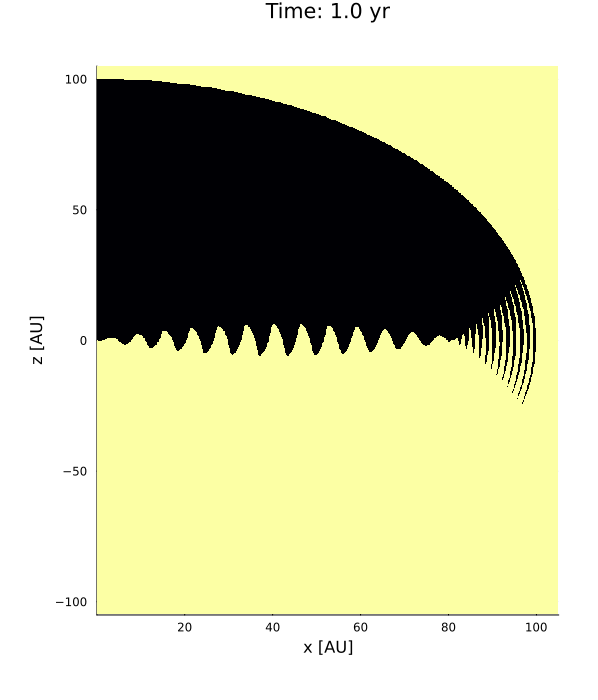

In [10]:
gr()

if vis_mode == "xz"
    divisor = 1 #AU
    title_string = "Time: $(time_val / yr) yr"
    xlabel, ylabel = ("x [AU]", "z [AU]")
else
    divisor = yr 
    title_string = "Radius: $(rad_val) AU"
    xlabel, ylabel = ("t [yr]", "z [AU]")
end     


Plots.heatmap( x ./ divisor , y, Bvals', 
                margin=8Plots.mm, size=(600, 700), #(850,1100),
                title=title_string, xlabel=xlabel, ylabel=ylabel, colorbar=false )

Animated GIF

In [ ]:
outdir = joinpath(@__DIR__, "..", "data")
mkpath(outdir)   # ensure folder exists
outfile = joinpath(outdir, "Bfield_xz.gif") 

"c:\\Users\\brian\\Documents\\CosmicDust\\Code\\HeliopauseBoundaryCode\\tests\\..\\data\\Bfield_tz.gif"

In [110]:
times = range(0.0, 11.0; length=2000) .* yr

0.0:173653.6268134067:3.471336e8

In [111]:
gr()

n_dense = 500  
vis_mode = "xz"
xspr = (0.1,105) 
yspr = xspr[2] - xspr[1]

anim = @animate for (i, t) in enumerate(times)

    @info "Rendering frame $i / $(length(times))  |  t = $(round(t/yr, digits=3)) yr"

    x, y, Bvals = B_data(
        input_parameters;
        radius = rad_val,
        timestamp   = t,
        n_x    = n_dense,
        n_t    = n_dense,
        n_z    = n_dense,
        visual_mode = vis_mode, 
        xspan_range = xspr, 
        yspan_range = yspr
    )

    if vis_mode == "xz"
        divisor = 1.0
        title_string = "Time: $(round(t / yr, digits=2)) yr"
        xlabel, ylabel = ("x [AU]", "z [AU]")
    else
        divisor = yr
        title_string = "Radius: $(rad_val) AU"
        xlabel, ylabel = ("t [yr]", "z [AU]")
    end

    heatmap(
        x ./ divisor,
        y,
        Bvals', 
        margin = 8Plots.mm,
        size   = (850, 1100),
        title  = title_string,
        xlabel = xlabel,
        ylabel = ylabel,
        colorbar = false 
    )
end


┌ Info: Rendering frame 1 / 2000  |  t = 0.0 yr
└ @ Main c:\Users\brian\Documents\CosmicDust\Code\HeliopauseBoundaryCode\tests\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X25sZmlsZQ==.jl:10
┌ Info: Rendering frame 2 / 2000  |  t = 0.006 yr
└ @ Main c:\Users\brian\Documents\CosmicDust\Code\HeliopauseBoundaryCode\tests\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X25sZmlsZQ==.jl:10
┌ Info: Rendering frame 3 / 2000  |  t = 0.011 yr
└ @ Main c:\Users\brian\Documents\CosmicDust\Code\HeliopauseBoundaryCode\tests\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X25sZmlsZQ==.jl:10
┌ Info: Rendering frame 4 / 2000  |  t = 0.017 yr
└ @ Main c:\Users\brian\Documents\CosmicDust\Code\HeliopauseBoundaryCode\tests\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X25sZmlsZQ==.jl:10
┌ Info: Rendering frame 5 / 2000  |  t = 0.022 yr
└ @ Main c:\Users\brian\Documents\CosmicDust\Code\HeliopauseBoundaryCode\tests\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X25sZmlsZQ==.jl:10
┌ Info: Rend

Animation("C:\\Users\\brian\\AppData\\Local\\Temp\\jl_0MyZ6X", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "001991.png", "001992.png", "001993.png", "001994.png", "001995.png", "001996.png", "001997.png", "001998.png", "001999.png", "002000.png"])

In [ ]:
gif(anim, outfile; fps=25); 

Extracting the z=0 line 

In [12]:
n_dense = 700 
vis_mode = "xz"
rad_val = 10.0 
time_val = 1.0 * yr 

xspr = (0.1, 105)
yspr = xspr[2] - xspr[1]

x, y, Bvals = B_data(input_parameters; radius=rad_val, timestamp=time_val, n_x=n_dense, n_t=n_dense, n_z=n_dense, 
                    visual_mode=vis_mode, xspan_range=xspr, yspan_range=yspr) 

(0.1:0.15007153075822605:105.0, -104.9:0.3001430615164521:104.9, [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0])

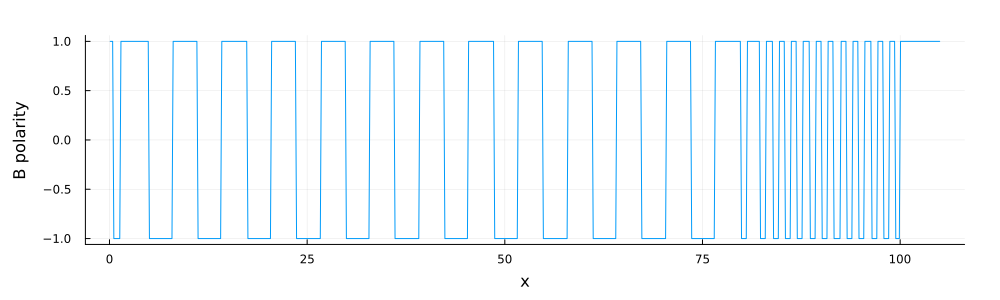

In [13]:
z0_idx = argmin(abs.(y .- 0.0))
B_z0 = Bvals[:, z0_idx]
x_z0 = x 

plot(x_z0, B_z0,
     xlabel = "x",
     ylabel = "B polarity",
     legend = false ,
     margin=7Plots.mm, 
     size = (1000,300))


In [15]:
i1, i2 = 50, 350

x_cut  = x[i1:i2]
B_cut  = B_z0[i1:i2]

s = sign.(B_cut)
edges = findall(diff(s) .!= 0)


15-element Vector{Int64}:
   4
  25
  45
  67
  87
 108
 129
 150
 170
 191
 212
 233
 253
 275
 295

In [16]:
x_edges = [(x_cut[e] + x_cut[e+1]) / 2 for e in edges]

15-element Vector{Float64}:
  7.978755364806867
 11.130257510729614
 14.131688125894135
 17.433261802575107
 20.434692417739626
 23.586194563662374
 26.737696709585123
 29.889198855507868
 32.89062947067239
 36.042131616595135
 39.193633762517884
 42.34513590844063
 45.34656652360515
 48.64814020028612
 51.649570815450645

In [19]:
diff_x_edges = diff(x_edges)
sum(diff_x_edges) / length( diff_x_edges )

3.1193439607602698

In [20]:
(27.0 * 86400.0) * (400_000) / AU

6.237521935531132

At 400 km/s, we travel 6.24 AU in 27 days, so half of this corresponds to the polarity change. The values of approximately 3.12 AU correspond to this. 

### Wave amplitude extraction

Code to extract the x-z location of a polarity change (peak or trough) for a given grid of polarity values at a given time. 

In [39]:
n_dense = 1000 
vis_mode = "xz"
rad_val = 50.0 
time_val = 0.0 * yr 

xspr = (0.1, 105)
zspr = xspr[2] - xspr[1]

x, z, Bvals = B_data(input_parameters; radius=rad_val, timestamp=time_val, n_x=n_dense, n_t=n_dense, n_z=n_dense, 
                    visual_mode=vis_mode, xspan_range=xspr, yspan_range=zspr) 

(0.1:0.10500500500500501:105.0, -104.9:0.21001001001001002:104.9, [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0])

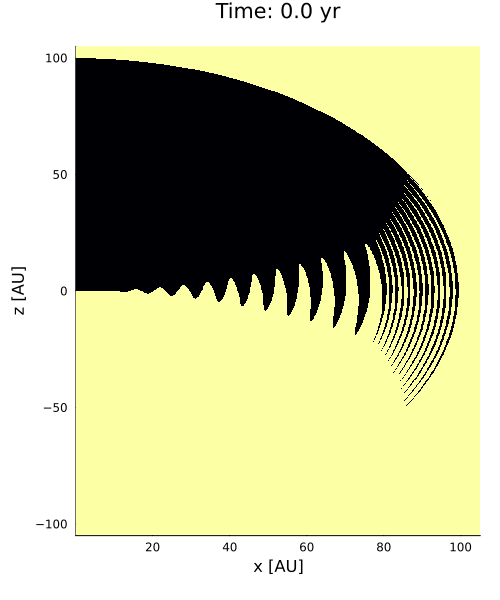

In [40]:
gr()

if vis_mode == "xz"
    divisor = 1 #AU
    title_string = "Time: $(time_val / yr) yr"
    xlabel, ylabel = ("x [AU]", "z [AU]")
else
    divisor = yr 
    title_string = "Radius: $(rad_val) AU"
    xlabel, ylabel = ("t [yr]", "z [AU]")
end     


Plots.heatmap( x ./ divisor , z, Bvals', 
                margin=3Plots.mm, size=(500, 600), #(850,1100),
                title=title_string, xlabel=xlabel, ylabel=ylabel, colorbar=false )

In [41]:
R = [sqrt(xi^2 + zj^2) for xi in x, zj in z]
# size(R) == size(Bvals)

diff_x = diff(x)
dr = sum(diff_x) / length(diff_x)  
rtol = dr / 2
mask = abs.(R .- rad_val) .< rtol

x_sel = Float64[]
z_sel = Float64[]
B_sel = Float64[]

for I in findall(mask)
    i, j = Tuple(I)  
    push!(x_sel, x[i])
    push!(z_sel, z[j])
    push!(B_sel, Bvals[i, j])
end


In [42]:
# Compute where polarity changes
sign_change = diff(sign.(B_sel)) .!= 0  # true where polarity switches

# Get indices of the changes
idx_change = findall(sign_change)

# Collect the corresponding coordinates, avoiding redundancy
xz_switch_coords = unique([(x_sel[k], z_sel[k]) for k in idx_change])

1-element Vector{Tuple{Float64, Float64}}:
 (49.24234234234234, -8.505405405405405)

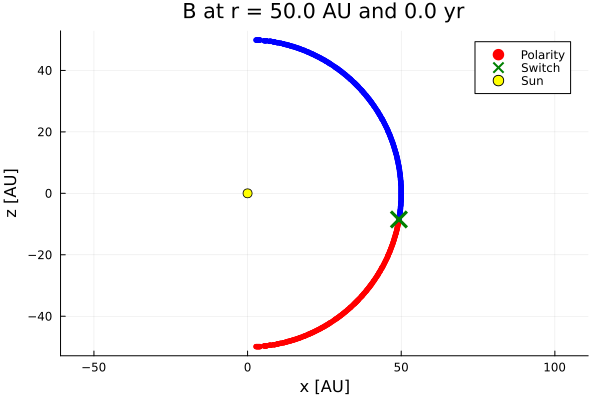

In [48]:
colors = map(b -> b > 0 ? :red : :blue, B_sel)


plt = scatter(x_sel, z_sel,
                color = colors,
                markersize=3, 
                markerstrokewidth = 0,
                xlabel = "x [AU]", ylabel = "z [AU]",
                aspect_ratio = :equal,
                title = "B at r = $rad_val AU and $(time_val / yr) yr", 
                label="Polarity")

scatter!(plt, [c[1] for c in xz_switch_coords], 
              [c[2] for c in xz_switch_coords], 
              color = :green, 
              marker = :x, 
              markersize = 8,        # increase marker size
              markerstrokewidth = 4,  # increase thickness of the x              
              label = "Switch")

# Overlay the origin marker
scatter!(plt, [0], [0], 
         marker = :circle,
         markersize = 5,
         color = :yellow,
         markerstrokecolor = :black,
         label = "Sun")

display(plt)

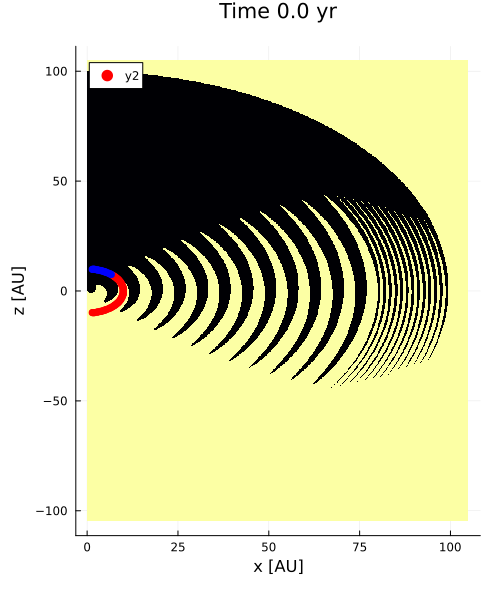

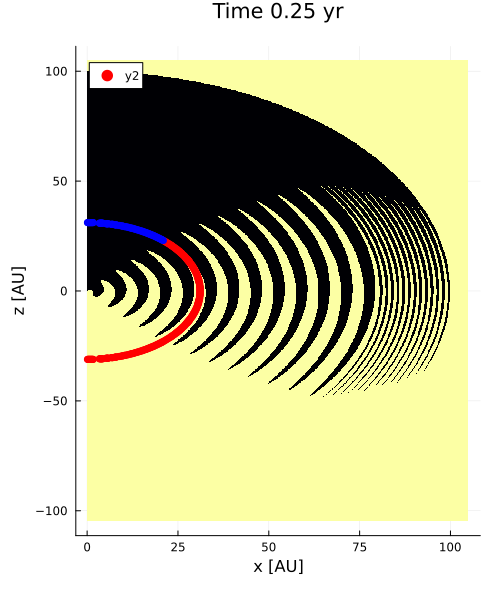

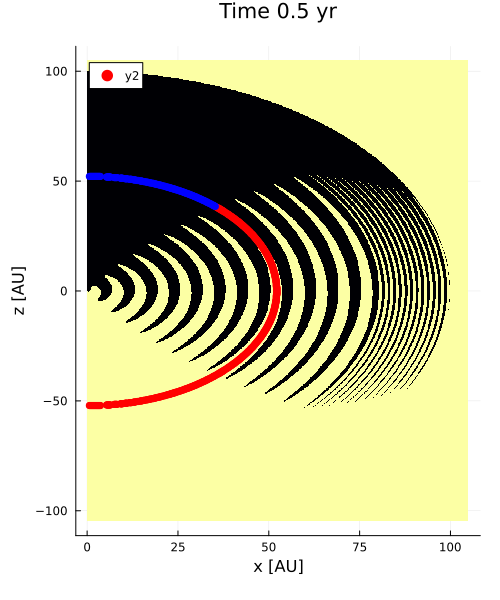

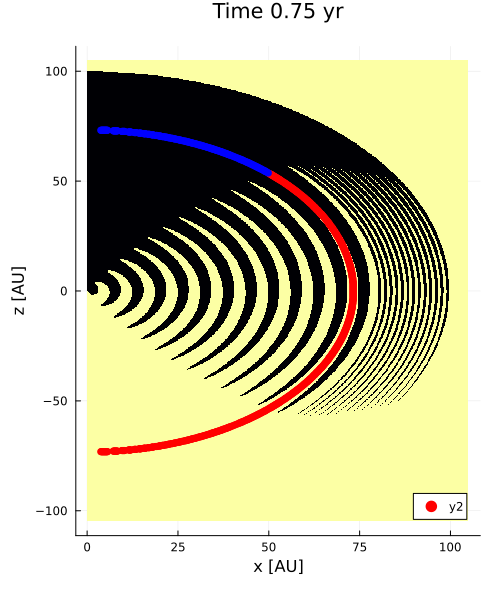

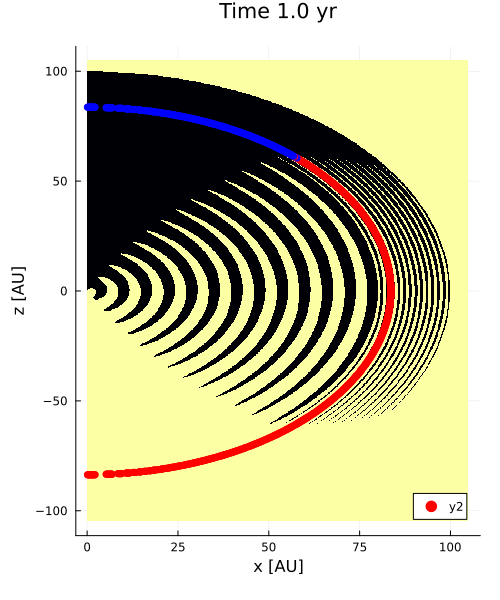

In [102]:
r_initial = 10.0 
t_initial_Bfield = 3.0 * yr 
t_initial = 0.0 
t_duration = 1.0 * yr 
t_range = range(t_initial, t_initial + t_duration, length=5) 
n_dense = 800 
vis_mode = "xz" 

saved_xs = Float64[] #Float64(length(t_range))
saved_zs = Float64[] #Float64(length(t_range)) 

for (i, t_val) in enumerate(t_range) 
    speed_TS = input_parameters["Termination_plasma_velocity"] 
    speed_HP = input_parameters["Heliosheath_plasma_velocity"] 
    dist_TS = input_parameters["distance_TS"] 
    
    if t_val < (dist_TS - r_initial * AU) / speed_TS 
        r_increment = speed_TS * (t_val - t_initial) 
    else 
        r_increment = (dist_TS - r_initial * AU) + speed_HP * (t_val - ( dist_TS - r_initial * AU) / speed_TS ) 
    end 
    
    rad_val = r_initial + (r_increment / AU) 
    time_val = t_val 
    
    xspr = (0.1, 105) 
    zspr = xspr[2] - xspr[1] 
    
    x, z, Bvals = B_data(input_parameters; radius=rad_val, timestamp=t_initial_Bfield+time_val, n_x=n_dense, n_t=n_dense, n_z=n_dense, 
                        visual_mode=vis_mode, xspan_range=xspr, yspan_range=zspr) 
    
    R = [sqrt(xi^2 + zj^2) for xi in x, zj in z] 
    
    plt = Plots.heatmap( x ./ 1 , z, Bvals', 
                margin=3Plots.mm, size=(500, 600), #(850,1100),
                title="Time $(t_val / yr) yr", xlabel="x [AU]", ylabel="z [AU]", colorbar=false )

    R = [sqrt(xi^2 + zj^2) for xi in x, zj in z] 

    diff_x = diff(x)
    dr = sum(diff_x) / length(diff_x)  
    rtol = dr / 2
    mask = abs.(R .- rad_val) .< rtol

    x_sel = Float64[]
    z_sel = Float64[]
    B_sel = Float64[]

    for I in findall(mask)
        i, j = Tuple(I)  
        push!(x_sel, x[i])
        push!(z_sel, z[j])
        push!(B_sel, Bvals[i, j])
    end


    colors = map(b -> b > 0 ? :red : :blue, B_sel)
    scatter!(plt, x_sel, z_sel, color = colors, markerstrokewidth = 0) 
    display(plt)

end

In [ ]:
r_initial = 10.0 
t_initial_Bfield = 1.0 * yr 
t_initial = 0.0 * yr 
t_duration = 1.5 * yr 
t_range = range(t_initial, t_initial + t_duration, length=10) 
n_dense = 1200 
vis_mode = "xz" 

saved_xs = Float64[]  
saved_zs = Float64[]  

speed_TS = input_parameters["Termination_plasma_velocity"] 
speed_HP = input_parameters["Heliosheath_plasma_velocity"] 
dist_TS = input_parameters["distance_TS"] 

for (i, t_val) in enumerate(t_range) 
    
    if t_val < (dist_TS - r_initial * AU) / speed_TS 
        r_increment = speed_TS * (t_val - t_initial) 
    else 
        r_increment = (dist_TS - r_initial * AU) + speed_HP * (t_val - ( dist_TS - r_initial * AU) / speed_TS ) 
    end 
    
    rad_val = r_initial + (r_increment / AU) 
    time_val = t_val 
    
    xspr = (0.1, 105) 
    zspr = xspr[2] - xspr[1] 
    
    x, z, Bvals = B_data(input_parameters; radius=rad_val, timestamp=t_initial_Bfield+time_val, n_x=n_dense, n_t=n_dense, n_z=n_dense, 
                        visual_mode=vis_mode, xspan_range=xspr, yspan_range=zspr) 
    
    R = [sqrt(xi^2 + zj^2) for xi in x, zj in z] 
    
    diff_x = diff(x) 
    dr = sum(diff_x) / length(diff_x) 
    
    rtol = dr / 2 
    mask = abs.(R .- rad_val) .< rtol 
    
    x_sel = Float64[] 
    z_sel = Float64[] 
    B_sel = Float64[] 
    
    for I in findall(mask) 
        i, j = Tuple(I) 
        push!(x_sel, x[i]) 
        push!(z_sel, z[j]) 
        push!(B_sel, Bvals[i, j]) 
    end 
    
    sign_change = diff(sign.(B_sel)) .!= 0 
    idx_change = findall(sign_change) 
    xz_switch_coords = unique([(x_sel[k], z_sel[k]) for k in idx_change])[1] 
    
    #println(xz_switch_coords) 
    
    push!(saved_xs, xz_switch_coords[1]) 
    push!(saved_zs, xz_switch_coords[2]) 

end

Z slopes: before TS = 19.10772310258549, after TS = 6.299249374478737
X slopes: before TS = 82.20520433694747, after TS = 20.21009174311933


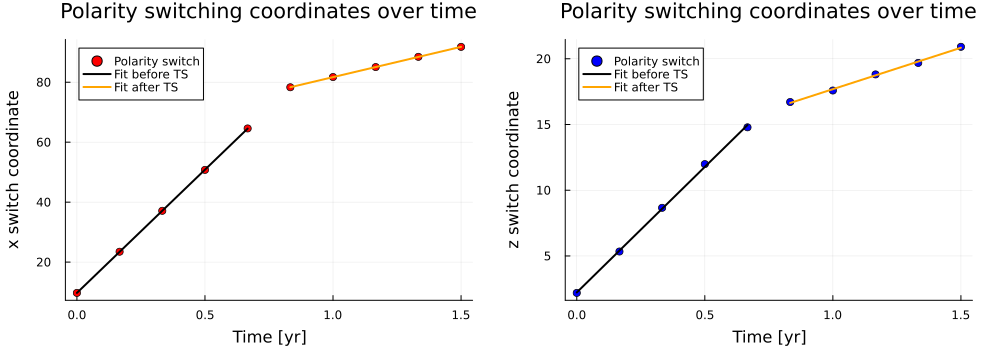

In [113]:
using Plots
gr()

# Convert time range to array
t_array = collect(t_range) ./ yr  # [yr]

time_to_TS = (dist_TS - r_initial * AU) / speed_TS / yr  # convert to years

# Split indices
idx1 = findall(t_array .<= time_to_TS)
idx2 = findall(t_array .> time_to_TS)

# Linear fit function
function linear_fit(t, y)
    A = [t ones(length(t))]       # design matrix for y = m*t + c
    coeffs = A \ y                # solve least squares
    return coeffs                 # [slope, intercept]
end

# Fit lines for z
coeffs_z1 = linear_fit(t_array[idx1], saved_zs[idx1])
coeffs_z2 = linear_fit(t_array[idx2], saved_zs[idx2])
println("Z slopes: before TS = $(coeffs_z1[1]), after TS = $(coeffs_z2[1])")

# Fit lines for x
coeffs_x1 = linear_fit(t_array[idx1], saved_xs[idx1])
coeffs_x2 = linear_fit(t_array[idx2], saved_xs[idx2])
println("X slopes: before TS = $(coeffs_x1[1]), after TS = $(coeffs_x2[1])")

# Prepare fitted lines for plotting
z_fit1 = coeffs_z1[1] .* t_array[idx1] .+ coeffs_z1[2]
z_fit2 = coeffs_z2[1] .* t_array[idx2] .+ coeffs_z2[2]

x_fit1 = coeffs_x1[1] .* t_array[idx1] .+ coeffs_x1[2]
x_fit2 = coeffs_x2[1] .* t_array[idx2] .+ coeffs_x2[2]

# Plots
plt1 = scatter(t_array, saved_zs,
               xlabel="Time [yr]", ylabel="z switch coordinate",
               marker=:circle, color=:blue, label="Polarity switch")
plot!(plt1, t_array[idx1], z_fit1, color=:black, lw=2, label="Fit before TS")
plot!(plt1, t_array[idx2], z_fit2, color=:orange, lw=2, label="Fit after TS")

plt2 = scatter(t_array, saved_xs,
               xlabel="Time [yr]", ylabel="x switch coordinate",
               marker=:circle, color=:red, label="Polarity switch")
plot!(plt2, t_array[idx1], x_fit1, color=:black, lw=2, label="Fit before TS")
plot!(plt2, t_array[idx2], x_fit2, color=:orange, lw=2, label="Fit after TS")

# Combine plots
plot(plt2, plt1, layout=(1,2), size=(1000,350), margin=5Plots.mm,
     title="Polarity switching coordinates over time")


In [ ]:
println("The X slopes correspond to the distance reached after 1 yr")
println("TS distance: $(400_000 * yr / AU) AU") 
println("HP distance: $(100_000 * yr / AU) AU")

The X slopes correspond to the distance reached after 1 yr
TS distance: 84.37981062787948 AU
HP distance: 21.09495265696987 AU


In [169]:
println("The Z slopes correspond to the tilt angle traced back from the position and time")

T_HCS = 11.0 * yr 
r0 = 10.0 * R_sun 
v_SW_TS = speed_TS  

println("Predicted ϵ: $(rad2deg( atan( coeffs_z1[1] / coeffs_x1[1] ) ) ) degrees") 

idx = 1
time = t_initial_Bfield + t_array[idx] 
r = norm( saved_xs[idx] * AU, saved_zs[idx] * AU ) #10.0 * AU 
ϵ_HCS = (180.0 / T_HCS * (time - ((r - r0) / v_SW_TS))) % 360.0 
ϵ_HCS += ϵ_HCS < 0.0 ? 360.0 : 0.0 

println("Calculated ϵ: $(ϵ_HCS) degrees")

The Z slopes correspond to the tilt angle traced back from the position and time
Predicted ϵ: 13.085435200865712 degrees
Calculated ϵ: 14.485631811743811 degrees
